# DTC

The deterministic training conditionals (DTC) method{cite}`dtcorig` is a sparse approximation for GPs. The DTC nomenclature was introduced by Candella and Rasmussen,{cite}`canrasuni` to describe the type of approximation made in this method. Instead of dealing with the exact GP model, the DTC method approximates the exact model using a second, approximate model. Strictly speaking, the probabilistic model assumed by DTC is not a valid GP model but has tractable inference and prediction stages.

$$
\def\Kxx{\mathbf{K}_{\mathbf{X}\mathbf{X}}}
 \def\Kxb{\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}}}
 \def\Kbx{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}}}
 \def\Kbb{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}}
 \def\Ksb{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kbs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Ksx{\mathbf{K}_{\mathbf{X^*}\mathbf{\bar{X}}}}
 \def\Kxs{\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X^*}}}
 \def\Kss{\mathbf{K}_{\mathbf{X^*}\mathbf{X^*}}}
 \def\fx{\mathbf{f}_{\mathbf{X}}}
 \def\fb{\mathbf{f}_{\mathbf{\bar{X}}}}
 \def\fs{\mathbf{f}_{\mathbf{X}^*}}
 \def\fstar{\mathbf{f}_{\mathbf{X^*}}}
 \def\X{\mathbf{x}}
 \def\xstar{\mathbf{x^*}}
 \def\X{\mathbf{X}}
 \def\Xb{\mathbf{\bar{X}}}
 \def\mb[#1]{\mathbf{#1}}
 \DeclareMathOperator*{\argmax}{arg\,max}
 \DeclareMathOperator*{\argmin}{arg\,min}
 \newcommand{\bs}[1]{\boldsymbol{#1}}
 \newcommand{\bm}[1]{\mathbf{#1}}
 \newcommand{\lrb}[1]{\left(#1\right)}
 \newcommand{\lrs}[1]{\left[#1\right]}
 \newcommand{\tr}[1]{\text{Tr}\left(#1\right)}
 \newcommand{\diag}[1]{\text{diag}\left(#1\right)}
$$

## Approximate generative model

Consider the following approximate model. Given a set of $M$ inputs $\Xb = \mathbf{\bar{x}}_{1:M}$, called the *inducing inputs*, we draw $M$ samples from the GP prior

$$\fb \sim \mathcal{N}\lrb{\bm{0}, \Kbb}.$$

Once the $\fb$ variables have been drawn, and given another set of $N$ inputs $\X = \mathbf{x}_{1:N}$, called the *training inputs*, we draw $N$ independent samples at each input $\mathbf{x}_{1:N}$ and the corresponding noisy training observations $\bm{y}$

$$\begin{align} \fx | \fb &\sim \mathcal{N}\lrb{ \Kxb \Kbb^{-1} \fb, \bm{0}}, \\
\bm{y} | \fx &\sim \mathcal{N}\lrb{\fx, \sigma^2 \bm{I}}.
\end{align}$$

For making test predictions, the 

DTC gets its name from the fact that the $\fx$ are deterministic when conditioned on $\Xb$. Note that the DTC involves different generative processes for the training and test data. Because of this, as Candela and Rasmussen {cite}`canrasuni` have pointed out, DTC does not correspond exactly to a GP. That's because the training and test points need to be identified before sampling them.

In this model, the entries of vector $\bm{y}$ are conditionally independent given $\fb$.

$$\begin{align} \fs | \fb &\sim \mathcal{N}\lrb{ \Kxs \Kss^{-1} \fs, \text{diag}\lrb{\Kss - \Ksb \Kbb^{-1} \Kbs}}, \\
\bm{y}^* | \fs &\sim \mathcal{N}\lrb{\fs, \sigma^2 \bm{I}}
\end{align}$$




In [6]:
import numpy as np
import matplotlib.pyplot as plt

def eq_covariance(x1,
                  x2,
                  coeff,
                  scale,
                  diag_only=False,
                  epsilon=None):

    # If not calculating diagonal only, expand to broadcast
    if not diag_only:

        x1 = x1[:, None, :]
        x2 = x2[None, :, :]

    # Compute differences
    diffs = x1 - x2

    # Compute quadratic form
    quad = - 0.5 * diffs ** 2 / scale
    quad = np.sum(quad, axis=-1)

    # Exponentiate and multiply by covariance coeff
    exp_quad = np.exp(quad)
    eq_cov = coeff ** 2 * exp_quad

    # Add epsilon for invertibility
    if epsilon is not None:

        eq_cov = eq_cov + epsilon * np.eye(eq_cov.shape[0])

    return eq_cov

In [7]:
# Set random seed - change to see different samples
np.random.seed(2)

# Num. inducing points (M), num. observations (N)
M = 4
N_train = 100
N_test = 100

# EQ hyperparameters
coeff = 1e0
scale = 1e-1
noise = 1e-1

# Pick inducing and observed inputs at random
x_ind = np.random.uniform(low=-2., high=2., size=(M, 1))
x_train = np.random.uniform(low=-4., high=4., size=(N_train, 1))
x_test = np.random.uniform(low=-4., high=4., size=(N_test, 1))
x_plot = np.linspace(-4., 4., 100)[:, None]

# Compute covariance matrix terms
K_ind_ind = eq_covariance(x_ind, x_ind, coeff, scale, epsilon=1e-12)
K_train_ind = eq_covariance(x_train, x_ind, coeff, scale)
K_test_ind = eq_covariance(x_test, x_ind, coeff, scale)
K_ind_test = eq_covariance(x_ind, x_test, coeff, scale)
K_test_test = eq_covariance(x_test, x_test, coeff, scale)
K_test_diag = eq_covariance(x_test, x_test, coeff, scale, diag_only=True)
K_plot_ind = eq_covariance(x_plot, x_ind, coeff, scale)
K_ind_plot = eq_covariance(x_ind, x_plot, coeff, scale)
K_plot_plot = eq_covariance(x_plot, x_plot, coeff, scale)

# Sample f_ind | x_ind
f_ind = np.dot(np.linalg.cholesky(K_ind_ind),
               np.random.normal(loc=0., scale=1., size=(M, 1)))

# Mean and variance of normal distribution of f_train | f_ind
f_train_mean = np.dot(K_train_ind, np.linalg.solve(K_ind_ind, f_ind))

y_train_mean = f_train_mean
y_train_var = noise ** 2 * np.ones_like(f_train_mean)
y_train = np.random.normal(y_train_mean, y_train_var ** 0.5)

# Mean and variance of normal distribution of f_test | f_ind
f_test_mean = np.dot(K_test_ind, np.linalg.solve(K_ind_ind, f_ind))
f_test_var = K_test_diag - np.einsum('ij, ji -> i',
                                     K_test_ind,
                                     np.linalg.solve(K_ind_ind, K_test_ind.T))
f_test_var = f_test_var[:, None]

y_test_mean = f_test_mean
y_test_cov = noise ** 2 * np.eye(N_test) + K_test_test - np.einsum('ij, jk -> ik', K_test_ind, np.linalg.solve(K_ind_ind, K_ind_test))
y_test = np.random.multivariate_normal(y_test_mean[:, 0], y_test_cov)

# Mean and variance of normal distribution of plotting
f_train_plot_mean = np.dot(K_plot_ind, np.linalg.solve(K_ind_ind, f_ind))
f_train_plot_var = np.zeros_like(f_train_plot_mean)

y_train_plot_mean = f_train_plot_mean
y_train_plot_std = (noise ** 2 * np.ones_like(f_train_plot_mean)) ** 0.5

f_test_plot_mean = np.dot(K_plot_ind, np.linalg.solve(K_ind_ind, f_ind))
f_test_plot_var = np.zeros_like(f_test_plot_mean)

y_test_plot_mean = f_test_plot_mean
y_test_plot_std = (np.diag(K_plot_plot - np.dot(K_plot_ind, np.linalg.solve(K_ind_ind, K_ind_plot)))[:, None] + \
                   noise ** 2 * np.ones_like(f_test_plot_mean)) ** 0.5

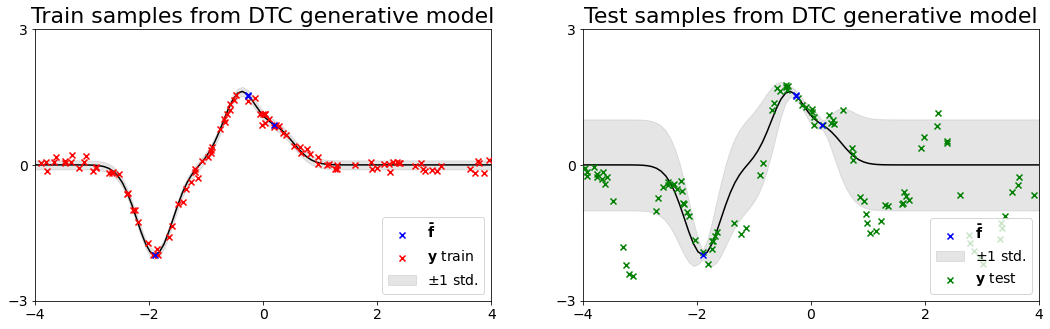

In [8]:
# Plot training and test generative process separately
plt.figure(figsize=(18, 5))

# Training data subplot
plt.subplot(121)

# Plot inducing points
plt.scatter(x_ind,
            f_ind,
            color='blue',
            marker='x',
            zorder=4,
            label=r'$\mathbf{\bar{f}}$')

# Plot training data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='x',
            zorder=3,
            label=r'$\mathbf{y}$ train')

# Plot mean of generative model
plt.plot(x_plot[:, 0],
         y_train_plot_mean[:, 0], color='black', 
         zorder=2)

# Plot noise of generative model
plt.fill_between(x_plot[:, 0],
                 (y_train_plot_mean - y_train_plot_std)[:, 0],
                 (y_train_plot_mean + y_train_plot_std)[:, 0],
                 color='gray',
                 zorder=1,
                 alpha=0.2,
                 label='$\pm 1$ std.')

# Plot formatting
plt.title('Train samples from DTC generative model', fontsize=22)
plt.xticks(np.arange(-4, 5, 2), fontsize=14)
plt.yticks(np.arange(-3, 4, 3), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-4., 4.])

# =============================================================================
# Plotting test generative process
# =============================================================================

# Test data subplot
plt.subplot(122)

# Plot inducing points
plt.scatter(x_ind,
            f_ind,
            color='blue',
            marker='x',
            zorder=4,
            label=r'$\mathbf{\bar{f}}$')


# Plot mean of generative model
plt.plot(x_plot[:, 0],
         y_train_plot_mean[:, 0], color='black', 
         zorder=2)

# Plot noise of generative model
plt.fill_between(x_plot[:, 0],
                 (y_test_plot_mean - y_test_plot_std)[:, 0],
                 (y_test_plot_mean + y_test_plot_std)[:, 0],
                 color='gray',
                 zorder=1,
                 alpha=0.2,
                 label='$\pm 1$ std.')

# Plot training data
plt.scatter(x_test,
            y_test,
            color='green',
            marker='x',
            zorder=3,
            label=r'$\mathbf{y}$ test')

# Plot formatting
plt.title('Test samples from DTC generative model', fontsize=22)
plt.xticks(np.arange(-4, 5, 2), fontsize=14)
plt.yticks(np.arange(-3, 4, 3), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-4., 4.])
plt.show()

## Posterior over inducing variables

The posterior over inducing variables is

$$\begin{align}p\lrb{\fb | \bm{y}} = \mathcal{N}\lrb{\fb; \bs{\Sigma} \bm{A}^\top \bm{y}, \bs{\Sigma}}, \text{ where } &\bs{\Sigma} = \sigma^2 \lrb{\Kbb^{-1} + \sigma^{-2}\Kbb^{-1}\Kbx\Kxb\Kbb^{-1}}^{-1}\\
\text{ and } & \bm{A} = \Kxb \Kbb^{-1} \end{align}$$

which we can rewrite, by defining $\bm{L}, \bm{V}$ and $\bm{M}$ such that

$$\begin{align}
\Kbb &= \bm{L}\bm{L}^\top\\
\bm{V} &= \bm{L}^{-1} \Kbx\\
\bm{M} &= \sigma^2 \bm{I} + \bm{V}\bm{V}^\top,
\end{align}$$

we can tidy up the posterior:

$$\begin{align}p\lrb{\fb | \bm{y}} = \mathcal{N}\lrb{\fb; \bm{L}\bm{M}^{-1}\bm{V}\bm{y}, \sigma^2 \bm{L} \bm{M}^{-1}\bm{L}}
\end{align}$$

## Marginal likelihood of the training data

The marginal likelihood of this approximate model is the probability of the data under the approximate likelihood integrated against the prior:

$$\begin{align}
p(\bm{y} | \X, \bs{\theta}) &= \int p\lrb{\bm{y} | \X, \bs{\theta}} p\lrb{\fx | \fb, \bs{\theta}}p\lrb{\fb | \bs{\theta}} d\fx d\fb\\
&= \mathcal{N}\lrb{\bm{y}; \bm{0}, \sigma^2 \bm{I} + \bm{V}^\top\bm{V}}
\end{align}$$

# Implementation

In [ ]:
import tensorflow as tf

class constant_mean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='eq_covariance'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class eq_covariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (1, -1))

        assert log_scales.shape[-1] == dim,                \
            f'Expected the size of scales at axis 2 '    + \
            f'to be dim, found shapes {scales.shape} '   + \
            f'and {dim}.'

        assert log_coeff.shape == (),                     \
            f'Expected coeff to be a single scalar, '   + \
            f'found coeff.shape == {coeff.shape}.'
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
    
    @property
    def scales(self):
        return (10 ** self.log_scales) ** 2.
    
    
    @property
    def coeff(self):
        return (10 ** self.log_coeff) ** 2.
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag_only=False,
                 epsilon=None):
        
        # Reshape input tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Check dimensions are correct
        assert (tf.rank(x1) == tf.rank(x2) == 2) and       \
               (x1.shape[1] == x2.shape[1] == self.dim),   \
            f'Expected x1 and x2 to have 2 dimensions '  + \
            f'and to both match self.dim at second '     + \
            f'dimension, instead found shapes '          + \
            f'{x1.shape} and {x2.shape}.'

        scales = self.scales
        
        # If not calculating diagonal only, expand to broadcast
        if not diag_only:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, :, :]

        # Compute differences
        diffs = x1 - x2

        # Compute quadratic form
        quad = - 0.5 * diffs ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)

        # Exponentiate and multiply by covariance coeff
        exp_quad = tf.exp(quad)
        eq_cov = self.coeff ** 2 * exp_quad
        
        # Add epsilon for invertibility
        if epsilon is not None:
            
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], dtype=self.dtype)

        return eq_cov

$$\begin{align}
\Kbb &= \bm{L}\bm{L}^\top\\
\bm{V} &= \bm{L}^{-1} \Kbx\\
\bm{M} &= \sigma^2 \bm{I} + \bm{V}\bm{V}^\top,
\end{align}$$

we can tidy up the posterior:

$$\begin{align}p\lrb{\fb | \bm{y}} = \mathcal{N}\lrb{\fb; \bm{L}\bm{M}^{-1}\bm{V}\bm{y}, \sigma^2 \bm{L} \bm{M}^{-1}\bm{L}}
\end{align}$$

## Marginal likelihood of the training data

The marginal likelihood of this approximate model is the probability of the data under the approximate likelihood integrated against the prior:

$$\begin{align}
p(\bm{y} | \X, \bs{\theta}) &= \int p\lrb{\bm{y} | \X, \bs{\theta}} p\lrb{\fx | \fb, \bs{\theta}}p\lrb{\fb | \bs{\theta}} d\fx d\fb\\
&= \mathcal{N}\lrb{\bm{y}; \bm{0}, \sigma^2 \bm{I} + \bm{V}^\top\bm{V}}
\end{align}$$

In [ ]:
class DTCGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 dtype,
                 name='dtc-gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train,
                                            dtype=dtype)
        
        self.y_train = tf.convert_to_tensor(y_train,
                                            dtype=dtype)
        
        self.x_ind = tf.convert_to_tensor(x_ind_init,
                                          dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
        
        
    def post_pred(self, x_pred):
        pass
    
    
    def log_lik(self):
        
        """
        Compute the log marginal likelihood.
        """
        
        N = self.x_train.shape[0]
        
        A = self.D_diag + self.noise
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=None)
        
        K_ind_train = self.cov(self.x_ind,
                               self.x_train)
        
        # Compute V
        C = K_ind_ind
        C = C + tf.einsum('ij, j, kj -> ik',
                          K_ind_train,
                          A ** -1,
                          K_ind_train)
        V = tf.linalg.cholesky(C)
        
        # Compute U
        U = tf.linalg.solve(V, K_ind_train / A)
        
        # Difference between mean and y_train
        diff = self.y_train - self.mean(x_train)
        
        # Compute quadratic form
        U_diff = tf.einsum('ij, j -> i',
                        U,
                        diff)
        
        quad = -0.5 * tf.reduce_sum(diff ** 2 / A)
        quad = quad + 0.5 * tf.reduce_sum(U_diff ** 2)
        
        logdet = tf.linalg.slogdet(C)[1]
        logdet = logdet - tf.linalg.slogdet(K_ind_ind)[1]
        logdet = logdet + tf.reduce_sum(tf.math.log(A))
        
        log_lik = -0.5 * N * np.log(2 * np.pi) - 0.5 * logdet + quad
        
        return log_lik
    
    
    @property
    def L(self):
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=None)
        
        L = tf.linalg.cholesky(K_ind_ind)
        
        return L
    
    
    @property
    def noise(self):
        return (10 ** self.log_noise) ** 2

## Notes and observations

- Strictly the generative model is not a GP, because the covariance function depends on knowing whether the datapoints are in the training or test set.

## References

```{bibliography} ./ref-dtc.bib
```